In [1]:
setwd("/projects/CARDIPS/analysis/epigenome_resource")
source("analyses/jennifer/notebooks/functions.R")

set.seed(5366)

# **Assign QTLs to independent GWAS locus**

## **read gwas manifest table**

In [2]:
traits = c("I20 Angina pectoris","I48 Atrial fibrillation and flutter","Body mass index (BMI)",
           "HDL cholesterol","LDL direct","I25 Chronic ischaemic heart disease","I21 Acute myocardial infarction",
           "Ventricular rate","QRS duration","Pulse rate","childhood obesity (eur)","birth weight (eur)",
            "Multivariate Longevity","fasting glucose","type 2 diabetes")

### Manifest found in Supplemental Table 5
manifest = fread("analyses/jennifer/gwas_independent/subset_manifest.txt", data.table = F)  %>% 
    filter(description %in% traits)


## **check files**

In [ ]:
for (trait in manifest$full_trait_id)
{
    file = paste("analyses/jennifer/gwas_independent/indep", paste(trait, "hg38_5e-08.txt", sep = "."), sep = "/")
    if (file.exists(file) == T)
    {
        data = fread(manifest[manifest$full_trait_id == trait,]$filename, data.table = F) %>% mutate(p = as.double(p)) %>% filter(p <= 5e-08)

#         fwrite(data, file, row.names = F, sep = "\t", col.names = F)
#         message(paste(file, "written"), appendLF = F)
        message(file)
        
    }
}

analyses/jennifer/gwas_independent/indep/timmers2020_healthspan_lifespan_longevity.hg38_5e-08.txt



## **Identify GWAS independent loci for each trait**

### **filter for variants passed genome-wide significant and in 1000 Genomes (already done! do not rerun)**

In [4]:
# read 1000 Genomes variants
bims = fread("analyses/jennifer/gwas_independent/reference/combined.renamed.bim", data.table = F, header = F)
colnames(bims) = c("chr", "id", "cm", "pos", "a1", "a2")

In [5]:
for (row in c(1:nrow(manifest)))
{
    outfile = paste("analyses/jennifer/gwas_independent/indep", paste(manifest[row,]$full_trait_id, "hg38_5e-08", "txt", sep = "."), sep = "/")
    message(manifest[row,]$full_trait_id, appendLF = F)
    data = fread(manifest[row,]$filename, data.table = F) %>% 
        mutate(p = as.double(p)) %>%
        filter(p <= 5e-08) %>%
        select(-id)
    data$chr = gsub("chr", "", data$chr)
    data2 = merge(data, bims %>% select(chr, pos, a1, a2, id), by = c("chr", "pos")) %>% 
        filter( (a1.x == a1.y & a2.x == a2.y) | (a1.x == a2.y & a2.x == a1.y) ) %>%
        mutate(id_1kg = paste(chr, pos, a1, a2, sep = "_"))
    fwrite(data2, outfile, row.names = F, sep = "\t")
    message(paste("Saved:", outfile), appendLF = F)
}

timmers2020_healthspan_lifespan_longevity


ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m✖[39m Column `id` doesn't exist.


### **prune variants**

https://www.nature.com/articles/s41588-023-01584-8

> "We identified genomic risk loci within our meta-analysis results using Functional Mapping and Annotation (FUMA) v1.3.8 (refs. 11,12). In brief, FUMA first identifies independent significant SNPs in the GWAS results by clumping all significant variants with the r2 threshold <0.6, and then a locus is defined by merging LD blocks of all independent significant SNPs within 250 kb of each other. Start and end of a locus is defined by identifying SNPs in LD with the independent significant SNPs (r2 ≥ 0.6) and defining a region that encompasses all SNPs within the locus. Lead SNPs within a locus are determined by further clumping the independent significant variants within the genomic locus (r2 ≥ 0.1). The 1000 Genome reference panel with all ancestries was used to calculate the r2."

In [5]:
# prune variants using variant count
pipeline = "path_to_05.3a.indep_gwas_prune.variant_ct.sh"

In [7]:
# These papers use variant count as a distance metric
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9282256/
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4342193/
# https://www.nature.com/articles/s41598-020-63457-y
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3581193/
# https://www.nature.com/articles/srep38600

In [8]:
windows = c(50, 100, 250, 500)
steps = c(5, 10, 20, 50)
r2s = c(0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8)

for (wind in windows[4])
{
    for (step in steps[1])
    {
        for (r2 in r2s[c(4)])
        {
            cmd = paste("qsub", pipeline, wind, step, r2)
            message(cmd)
            system(cmd)
        }
    }
}

qsub /projects/CARDIPS/analysis/epigenome_resource/manuscript/notebooks/02.0.prune_gwas_variants_with_counts.sh 500 5 0.5



### **in response to reviewers: how far does 500 variants get?**

In [3]:
# qtls = fread("analyses/tim/gwas_coloc/scripts/qtls_to_coloc_with_gwas.txt", data.table = F) %>% filter(analysis == "eqtls")
qtls = fread("analyses/tim/ld_modules/modules/all_modules_091124.txt", data.table = T)


In [114]:
winds = unlist(lapply(qtls$path_to_qtl, function(file)
{
    data = fread(file, data.table = F) %>% arrange(pos) %>% mutate(rank = c(1:nrow(.)))
    lead = data %>% arrange(pval) %>% head(1) %>% pull(rank)
    wind = data %>% filter(rank >= (lead - 500) & rank <= (lead + 500))
    wind = min(wind$pos) - max(wind$pos)
    return(wind)
}))


save(winds, file = "analyses/jennifer/gwas_independent/kb_distance_for_500snps_window.robj")

In [3]:
load("analyses/jennifer/gwas_independent/kb_distance_for_500snps_window.robj", verbose =T)

Loading objects:
  winds


In [4]:
median(abs(winds) / 1e3)
mean(abs(winds) / 1e3)

[1] 329.003

[1] 385.8524

Warning message in int_abline(a = a, b = b, h = h, v = v, untf = untf, ...):
“"fonttype" is not a graphical parameter”


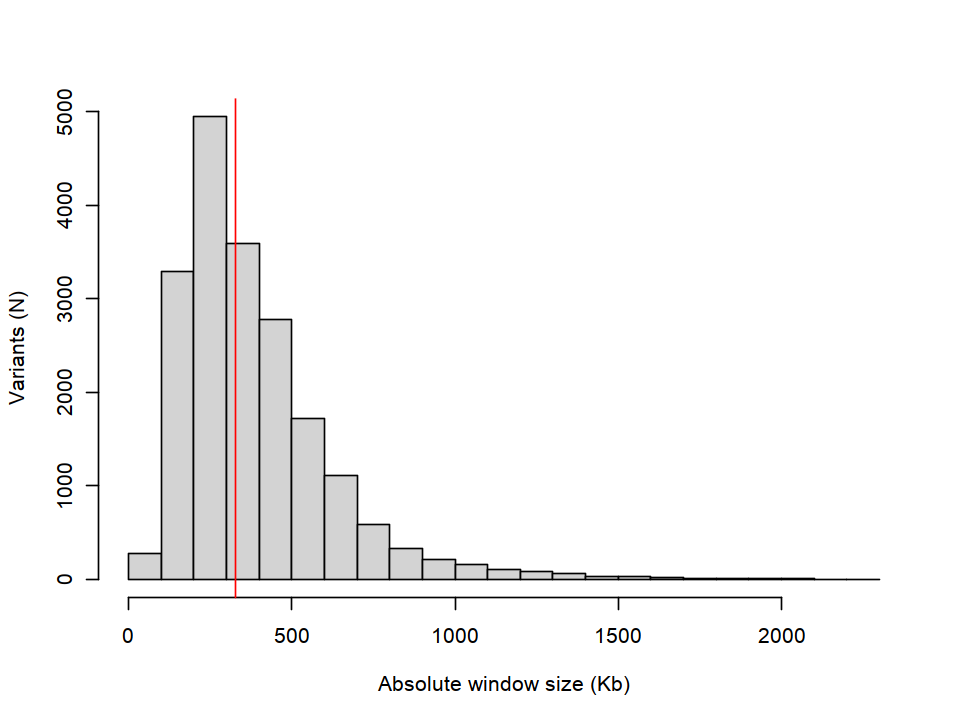

In [5]:
psize(w = 8, h = 6)
hist(abs(winds) / 1e3, main = "", xlab = "Absolute window size (Kb)", ylab = "Variants (N)")
abline(v = median(abs(winds)) / 1e3, col = "red", fonttype = "arial")

### **number of GWAS indep loci per trait**

In [3]:
# kb = 50
# step = 5
# r2 = 0.75
type = "ct"

windows = c(50, 100, 250, 500)
steps = c(5, 10, 20, 50)
r2s = c(0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 0.8)

gwas_index = as.data.frame(rbindlist(lapply(windows[4], function(kb)
{
    as.data.frame(rbindlist(lapply(steps[1], function(step)
    {
        as.data.frame(rbindlist(lapply(r2s[2], function(r2)
        {
            as.data.frame(rbindlist(lapply(manifest$full_trait_id, function(trait)
            {
                message(trait, appendLF = F)
                as.data.frame(rbindlist(lapply(c(1:22), function(i)
                {   
                    # Filename for pruned variants
                    file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                                 paste(trait, "hg38_5e-08", sep = "."), 
                                 paste(paste0("chr", i), paste(paste0(kb, type), paste0(step, "step"), paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")

                    # Filename for all genome-wide sig GWAS variants
                    tested = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                                 paste(trait, "hg38_5e-08", sep = "."), 
                                 paste(paste0("chr", i),  "snps", sep = "."), sep = "/")
                    
                    # Filter snps that are on the chromosome of interest
                    tested     = data.frame(snp = readLines(tested)) %>% distinct()
                    tested$chr = as.numeric(unlist(lapply(tested$snp, function(x) { unlist(strsplit(x, "_"))[1] })))
                    tested$pos = as.numeric(unlist(lapply(tested$snp, function(x) { unlist(strsplit(x, "_"))[2] })))
                    tested     = tested %>% filter(chr == i)
                    
                    if (file.exists(file))
                    {
                        snps = readLines(file)

                        # Remove MHC regions
                        if (i == 6)
                        {
                            tmp = data.frame(snp = snps) %>% mutate(pos = unlist(lapply(snp, function(x) { as.numeric(unlist(strsplit(x, "_"))[2]) })))
                            tmp = tmp %>% filter(pos <= 28510120 | pos >= 33480577)
                            snps = tmp$snp
                        }

                        data.frame(index = snps) %>%
                            mutate(description = manifest[manifest$full_trait_id == trait,]$description,
                                   full_trait_id = trait,
                                   kb = kb,
                                   step = step,
                                   r2 = r2,
                                   chr = i,
                                   var_tested = length(unique(tested$snp)))
                    } else
                    {
#                         message(paste(file, "missing"))
                        # If "prune.in" does not exist, it is likely beccause there is only one locus 
                        # so plink throws an error and therefore doesn't run
                        # if there is only one locus, no need to prune
                        if (length(unique(tested$snp)) == 1)
                        {
                            data.frame(index = tested$snp) %>%
                                mutate(description = manifest[manifest$full_trait_id == trait,]$description,
                                       full_trait_id = trait,
                                       kb = kb,
                                       step = step,
                                       r2 = r2,
                                       chr = i,
                                       var_tested = length(unique(tested$snp)))
                        } else
                        {
                            data.frame(index = NA) %>%
                                mutate(description = manifest[manifest$full_trait_id == trait,]$description,
                                       full_trait_id = trait,
                                       kb = kb,
                                       step = step,
                                       r2 = r2,
                                       chr = i,
                                       var_tested = length(unique(tested$snp)))
                        }
                            
                    }
                })))  
              })))  
        })))
    })))
})))



timmers2020_healthspan_lifespan_longevity
biomarkers-30760-both_sexes-irnt.meta
biomarkers-30780-both_sexes-irnt.meta
BW3_EUR_summary_stats
CHILDHOOD_OBESITY.eur
continuous-12336-both_sexes-irnt.meta
continuous-12340-both_sexes-irnt.meta
continuous-23104-both_sexes-irnt.meta
continuous-4194-both_sexes-irnt.meta
icd10-I20-both_sexes.meta
icd10-I21-both_sexes.meta
icd10-I25-both_sexes.meta
icd10-I48-both_sexes.meta
MAGIC1000G_FG_EUR
Mahajan.NatGenet2018b.T2D.European_sorted


In [4]:
# remove empty entries
a = gwas_index %>% filter(is.na(index))
table(a$var_tested)

gwas_index = gwas_index %>% filter(!is.na(index))


 0 
80 

In [5]:
gwas_index$index_trait = paste(gwas_index$index, gwas_index$full_trait_id)

message(paste("# loci:", length(unique(gwas_index$index_trait))))

# loci: 5192



In [6]:
# number of independent associations per gwas trait
gwas_index %>% group_by(description, full_trait_id) %>% dplyr::summarise(nloci = n())

`summarise()` has grouped output by 'description'. You can override using the
`.groups` argument.


description,full_trait_id,nloci
<chr>,<chr>,<int>
Body mass index (BMI),continuous-23104-both_sexes-irnt.meta,1519
HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1837
I20 Angina pectoris,icd10-I20-both_sexes.meta,34
I21 Acute myocardial infarction,icd10-I21-both_sexes.meta,21
I25 Chronic ischaemic heart disease,icd10-I25-both_sexes.meta,81
I48 Atrial fibrillation and flutter,icd10-I48-both_sexes.meta,90
LDL direct,biomarkers-30780-both_sexes-irnt.meta,752
Multivariate Longevity,timmers2020_healthspan_lifespan_longevity,35
Pulse rate,continuous-4194-both_sexes-irnt.meta,133


### **optional: visually check**

In [106]:
data = fread(manifest[manifest$full_trait_id %like% "Mahajan",]$filename, data.table = F)

In [107]:
chr = 20
chrom = paste0("chr", chr)
data2 = data[data$chr == chrom,]
data2$p = as.double(data2$p)

In [108]:
trait = manifest[manifest$full_trait_id %like% "Mahajan",]$full_trait_id
i = chr
kb = 500
type = "ct"
step = 5
r2 = 0.1

file = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
             paste(trait, "hg38_5e-08", sep = "."), 
             paste(paste0("chr", i), paste(paste0(kb, type), paste0(step, "step"), paste0("r", r2), sep = "_"), "prune.in", sep = "."), sep = "/")

pruned = readLines(file)
pruned = as.numeric(unlist(lapply(pruned, function(x) { unlist(strsplit(x, "_"))[2] })))

message(paste("# Indep Loci:", length(unique(pruned))))

pruned

# Indep Loci: 10



[1] 21479795 33793531 33940059 44357077 44370990 44413724 46953833 50227811
 [9] 52606165 58812303

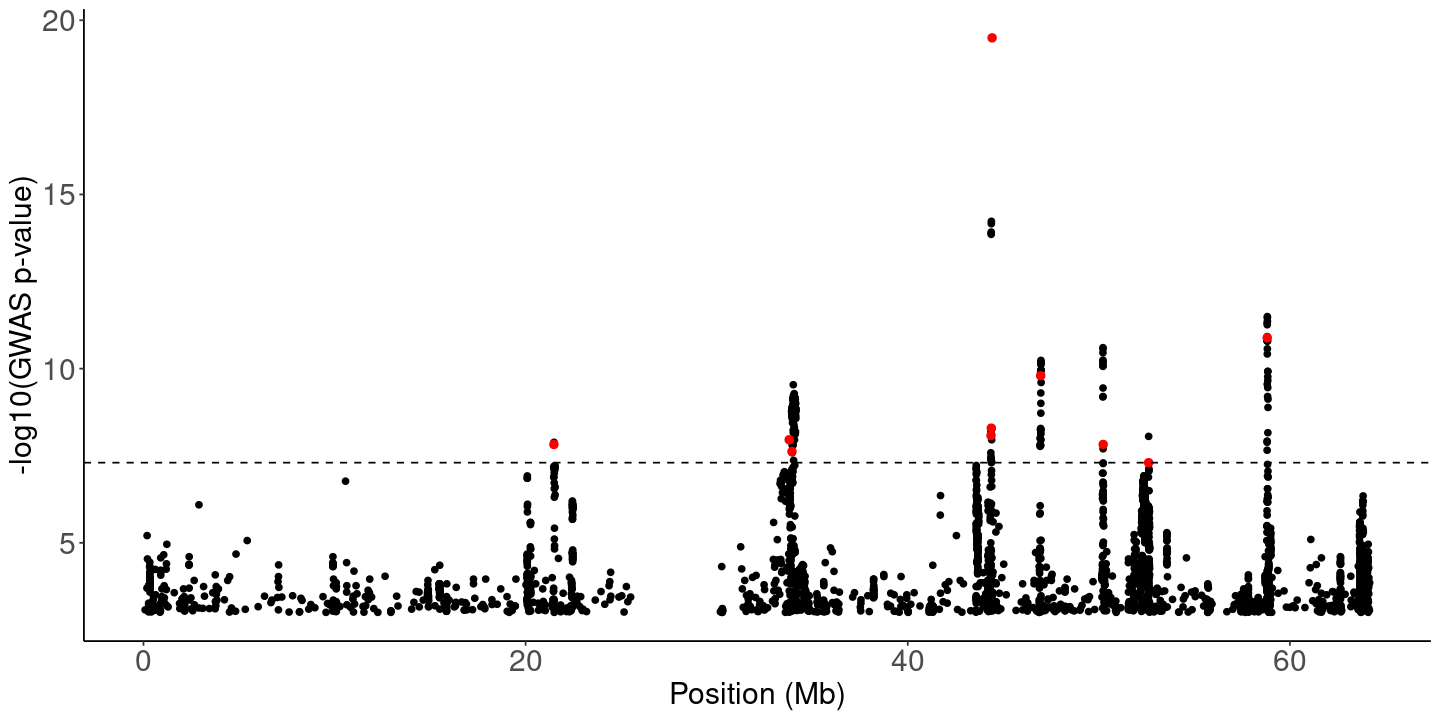

In [15]:
psize(w = 12, h = 6)
ggplot(data2 %>% filter(p < 1e-3), aes(x = pos/1e6,  y = -log10(p))) + geom_point() + jn_classic + 
    geom_point(data = data2 %>% filter(pos %in% pruned), color = "red", size = 2) + 
    geom_hline(yintercept = -log10(5e-08), linetype = "dashed") + 
    xlab("Position (Mb)") + ylab("-log10(GWAS p-value)")

# **Which GWAS loci are explained by eQTLs?**

In [ ]:
gwas_coloc = fread("~/projects/Resource/Figshare/all.gwas_summary.2024_0925.txt", data.table = F)  %>%
    filter(full_trait_id %in% manifest$full_trait_id) %>% dplyr::relocate(description, .before = full_trait_id) %>%
    filter(coloc_gwas == T & Nominated == T) 

In [10]:
length(unique(c(gsub("VAR_", "", gwas_coloc$topsnp), gwas_index$index)))
length(unique(gsub("VAR_", "", gwas_coloc$topsnp)))
length(unique(gwas_index$index))
nrow(gwas_index)

[1] 5554

[1] 644

[1] 4977

[1] 5192

In [11]:
topsnps = gwas_coloc$topsnp
length(topsnps)
length(topsnps[ grepl("[A-Z]$",topsnps)])

[1] 863

[1] 863

In [282]:
writeLines(sort(unique(c(gsub("VAR_", "", gwas_coloc$topsnp), gwas_index$index))),
           "analyses/tim/gwas_coloc2/qtl_tag2/gwas_topsnp2.txt", sep = "\n")

## **run plink tags**

In [283]:
ct = 500
step = 5
r2 = 0.1
type = "ct"
r2_tag = 0.7
wind = 350

pipeline = "path_to_05.3b.tag_gwas_index_with_topsnp.sh"
cmd = paste("qsub", pipeline, ct, step, r2, type, r2_tag, wind)

message(cmd)
# system(cmd)

qsub /projects/CARDIPS/analysis/epigenome_resource/analyses/tim/gwas_coloc2/scripts/02.0.tag_gwas_index_with_topsnp.sh 500 5 0.1 ct 0.7 350



## **pair each QTL with GWAS locus**

In [12]:
kb = 500
wind = 5
r2 = 0.1
type = "ct"

In [36]:

# link each GWAS index to the QTL-GWAS variant
link = as.data.frame(rbindlist(lapply(c("iPSC","CVPC","PPC"), function(tissue)
{
    message(paste0(tissue, "========="), appendLF = F)

    # 1. Get coloc results for relevant traits and tissue
    this2 = gwas_coloc %>% 
            ungroup() %>%
            select(-tissue) %>% 
            filter(Cluster_ID %like% tissue) %>%
            mutate(cluster_gwas = paste(Cluster_ID, full_trait_id)) 

    print(nrow(this2))
    
    if (nrow(this2) != 0)
    {
        as.data.frame(rbindlist(lapply(unique(manifest$description), function(trait)
        {
            message(trait, appendLF = F)
            full_trait_id = manifest[manifest$description == trait,]$full_trait_id
            
            tags = as.data.frame(rbindlist(lapply(c(1:22), function(i)
            {
                # File for tags
                tags_file = paste(getwd(), "analyses/tim/gwas_coloc2/qtl_tag", 
                             paste(full_trait_id, "hg38_5e-08", sep = "."), 
                             paste(paste0("chr", i), 
                                   paste(paste0(kb, type), 
                                         paste0(wind, "step"), 
                                         paste0("r", r2), sep = "_"), 
                                   "tags.list", sep = "."), sep = "/")

                # File for GWAS loci
                gwas_loci = paste(getwd(), "analyses/jennifer/gwas_independent/indep", 
                                  paste(full_trait_id, "hg38_5e-08", sep = "."), 
                                  paste(paste0("chr", i), 
                                        paste(paste0(kb, type), 
                                              paste0(wind, "step"), 
                                              paste0("r", r2), sep = "_"), 
                                        "prune.in", sep = "."), sep = "/")
                
                
                if (file.exists(tags_file) & file.exists(gwas_loci))
                {
                    # Read
                    gwas_loci = readLines(gwas_loci)
    
                    tags = fread(tags_file, data.table = F) 

                    if (nrow(tags) != 0)
                    {
                        # 2. SNP = GWAS Locus, TAGS = QTLs
                        tags = tags %>% 
                            filter(SNP %in% gwas_loci) %>% 
                            tidyr::separate_rows(TAGS, sep = "[|]") 

                        # 3. If GWAS Locus does not tag a QTL, set tag to itself
                        tags$TAGS = ifelse(tags$TAGS == "NONE", tags$SNP, tags$TAGS)
#                         return(tags)
                    }
                    return(tags)
                    
                } 
# #                 else
#                 {
#                     message(paste("Skipping", i, tags_file, file.exists(gwas_loci)), appendLF = F)
#                 }
            })))
            
            # Have GWAS index tag itself (same as above)
            if (nrow(tags) > 0)
            {
                tags = rbind(tags, tags %>% mutate(TAGS = SNP)) %>% select(SNP, TAGS) %>% distinct()

            }

            this3 = this2[this2$description == trait,] %>% 
                select(Cluster_ID, full_trait_id, description, topsnp,qtl_combo) %>% 
                ## add back "qtl_combo, n_members"
                distinct() %>% 
                dplyr::rename(TAGS = topsnp)
            
            this3$TAGS = gsub("VAR_", "", this3$TAGS)

            if (nrow(this3) > 0)
            {
                # Link QTL to GWAS
                out = merge(tags, this3 , by = c("TAGS"))

                # Some might not be in the 1000 Genomes Reference Panel so not tagged
                if (nrow(out) > 0)
                {
                    out$qtl_pos = as.numeric(unlist(lapply(out$TAGS, function(x) { unlist(strsplit(x, "_"))[2] })))
                    out$gwas_pos = as.numeric(unlist(lapply(out$SNP, function(x) { unlist(strsplit(x, "_"))[2] })))
                    out$dist = abs(out$gwas_pos - out$qtl_pos)
                    out = out %>% dplyr::group_by(Cluster_ID) %>% dplyr::filter(dist == min(dist))
                }

                # Add other GWAS loci
                out = merge(gwas_index %>% dplyr::rename(gwas_index = index), 
                            out %>% select(TAGS, SNP, description, full_trait_id, Cluster_ID,qtl_combo) %>% dplyr::rename(qtl_index = TAGS, gwas_index = SNP), 
                            by = c("gwas_index", "description", "full_trait_id"), all.x = T)
                ### add back  qtl_combo, n_members
                return(out)
            }
        })))
    }
}))) %>% 
    mutate(cluster_gwas = paste(Cluster_ID, full_trait_id)) %>% 
    distinct()  
    
link$index_trait = paste(link$gwas_index, link$full_trait_id)
link$cluster_gwas = ifelse(is.na(link$Cluster_ID), NA, link$cluster_gwas)

a = link %>% filter(is.na(Cluster_ID))
b = link %>% filter(!is.na(Cluster_ID))

dup = intersect(a$index_trait, b$index_trait)

a = a %>% filter(!index_trait %in% dup)

link = rbind(a, b)


iPSC=========


[1] 295


Multivariate Longevity
HDL cholesterol
LDL direct
birth weight (eur)
childhood obesity (eur)
Ventricular rate
QRS duration
Body mass index (BMI)
Pulse rate
I20 Angina pectoris
I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I48 Atrial fibrillation and flutter
fasting glucose
type 2 diabetes
CVPC=========


[1] 344


Multivariate Longevity
HDL cholesterol
LDL direct
birth weight (eur)
childhood obesity (eur)
Ventricular rate
QRS duration
Body mass index (BMI)
Pulse rate
I20 Angina pectoris
I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I48 Atrial fibrillation and flutter
fasting glucose
type 2 diabetes
PPC=========


[1] 224


Multivariate Longevity
HDL cholesterol
LDL direct
birth weight (eur)
childhood obesity (eur)
Ventricular rate
QRS duration
Body mass index (BMI)
Pulse rate
I20 Angina pectoris
I21 Acute myocardial infarction
I25 Chronic ischaemic heart disease
I48 Atrial fibrillation and flutter
fasting glucose
type 2 diabetes


In [37]:
table(gwas_coloc$qtl_combo)


           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
             347               51               17               50 
            eQTL       eQTL-haQTL            haQTL 
             300               13               85 

In [38]:
# gwas_coloc3 %>% filter(Cluster_ID == "CVPC_292")

In [39]:
# check that each qtl cluster was assigned to only one gwas locus
link %>% filter(duplicated(cluster_gwas) == T & !is.na(Cluster_ID))

gwas_index,description,full_trait_id,kb,step,r2,chr,var_tested,index_trait,qtl_index,Cluster_ID,qtl_combo,cluster_gwas
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>


### Check all independent GWAS loci are in the table and not lost

In [40]:
a = link %>% select(gwas_index, full_trait_id) %>% distinct() %>% group_by(full_trait_id) %>% dplyr::summarise(total = n())

message(paste("# total loci:", sum(a$total)))

# total loci: 5192



### Are all clusters assigned to a locus? If not, assign them to the nearest GWAS signal.

    - This occurs if the lead SNP is not in the 1000 Genomes genotype panel, so can't calculate LD

In [41]:
# how many colocalized clusters have not been assigned?
a = gwas_coloc %>% 
    select(Cluster_ID, description, full_trait_id, topsnp,  topsnp_pp,qtl_combo) %>% distinct() %>% 
    ## add back qtl_combo, n_members
    mutate(cluster_gwas = paste(Cluster_ID, full_trait_id))

a$paired_with_gwas = ifelse(a$cluster_gwas %in% link[!is.na(link$Cluster_ID),]$cluster_gwas, T, F)
a$chrom = unlist(lapply(a$topsnp, function(x) { as.numeric(unlist(strsplit(x, "_"))[2]) }))

table(a$paired_with_gwas)

# get clusters that wer enot yet asssigned and get their topsnp_pp
a = a %>% filter(paired_with_gwas == F) %>% arrange(full_trait_id, chrom) 
a$pos = unlist(lapply(a$topsnp, function(x) { as.numeric(unlist(strsplit(x, "_"))[3]) }))
a = a %>% group_by(cluster_gwas) %>% filter(topsnp_pp == max(topsnp_pp)) 


FALSE  TRUE 
  468   395 

In [42]:
a2 = as.data.frame(rbindlist(lapply(unique(a$full_trait_id), function(x)
{
    message(x, appendLF = F)
    
    # get index snp for each association locus
    this = link %>% filter(full_trait_id == x)
    this$gwas_pos = as.numeric(unlist(lapply(this$gwas_index, function(x) { unlist(strsplit(x, "_"))[2] })))
    this$gwas_chr = as.numeric(unlist(lapply(this$gwas_index, function(x) { unlist(strsplit(x, "_"))[1] })))
#     return(this)
    # get the missing QTL clusters that colocalized with the trait
    this_a = a %>% filter(full_trait_id == x)
#     return(this_a)
    
    # iterate through each QTL cluster
    as.data.frame(rbindlist(lapply(c(1:nrow(this_a)), function(row)
    {
        # calculate their distance to each GWAS locus
        this2 = this %>% filter(gwas_chr == this_a[row,]$chrom) %>% select(gwas_index, description, full_trait_id, gwas_chr, gwas_pos, chr) %>% distinct()

        this2$dist = abs(this2$gwas_pos - this_a[row,]$pos)
        
        # get the closest GWAS locus
        this2 = this2 %>% filter(dist == min(dist)) %>% distinct() 
        
        if (nrow(this2) > 1)
        {
            message(paste(this_a[row,]$Custer_ID, "is close to multiple GWAS loci of same distance. Selecting one.."))
            print(this2)
        }

        out = this2 %>% filter(duplicated(gwas_index) == F)
        out$qtl_index = unlist(lapply(this_a[row,]$topsnp, function(x) { paste(unlist(strsplit(x, "_"))[2:3], collapse = "_") }))
        out$Cluster_ID = this_a[row,]$Cluster_ID
        out$qtl_combo = this_a[row,]$qtl_combo
#         out$n_members = this_a[row,]$n_members
        out$cluster_gwas = paste(out$Cluster_ID, out$full_trait_id)
        out$index_trait = paste(out$gwas_index, out$full_trait_id)
        out[,c("dist", "gwas_pos", "gwas_chr")] = NULL
        return(out)
    })))
})))
nrow(a2)
head(a2)

biomarkers-30760-both_sexes-irnt.meta
biomarkers-30780-both_sexes-irnt.meta
BW3_EUR_summary_stats
CHILDHOOD_OBESITY.eur
continuous-12336-both_sexes-irnt.meta
continuous-12340-both_sexes-irnt.meta
continuous-23104-both_sexes-irnt.meta
continuous-4194-both_sexes-irnt.meta
icd10-I20-both_sexes.meta
icd10-I21-both_sexes.meta
icd10-I25-both_sexes.meta
icd10-I48-both_sexes.meta
MAGIC1000G_FG_EUR
Mahajan.NatGenet2018b.T2D.European_sorted
timmers2020_healthspan_lifespan_longevity


[1] 468

,gwas_index,description,full_trait_id,chr,qtl_index,Cluster_ID,qtl_combo,cluster_gwas,index_trait
,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1_93444330_C_A,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1,1_93392735,CVPC_7182,caQTL,CVPC_7182 biomarkers-30760-both_sexes-irnt.meta,1_93444330_C_A biomarkers-30760-both_sexes-irnt.meta
2,1_205770138_C_T,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1,1_205766484,CVPC_10342,caQTL,CVPC_10342 biomarkers-30760-both_sexes-irnt.meta,1_205770138_C_T biomarkers-30760-both_sexes-irnt.meta
3,1_62498080_A_AT,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1,1_62553181,CVPC_14537,caQTL,CVPC_14537 biomarkers-30760-both_sexes-irnt.meta,1_62498080_A_AT biomarkers-30760-both_sexes-irnt.meta
4,1_62806467_G_A,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1,1_62694611,CVPC_16038,haQTL,CVPC_16038 biomarkers-30760-both_sexes-irnt.meta,1_62806467_G_A biomarkers-30760-both_sexes-irnt.meta
5,1_205770138_C_T,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1,1_205766484,CVPC_3814,eQTL,CVPC_3814 biomarkers-30760-both_sexes-irnt.meta,1_205770138_C_T biomarkers-30760-both_sexes-irnt.meta
6,1_26573196_C_A,HDL cholesterol,biomarkers-30760-both_sexes-irnt.meta,1,1_26693642,iPSC_1858,eQTL,iPSC_1858 biomarkers-30760-both_sexes-irnt.meta,1_26573196_C_A biomarkers-30760-both_sexes-irnt.meta


In [43]:
# make sure that there are no dup entries for each QTL cluster-gwas
a2 %>% filter(duplicated(cluster_gwas) == T)

gwas_index,description,full_trait_id,chr,qtl_index,Cluster_ID,qtl_combo,cluster_gwas,index_trait
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>


In [44]:
# Keep signals that were empty but now paired with a QTL
tmp1 = a2
colnames(tmp1)
nrow(tmp1)
# Keep signals that already have cluster id
tmp2 = link %>% filter(!is.na(Cluster_ID))
colnames(tmp2)

# keep signals that did not colocalize
tmp3 = link %>% filter(!index_trait %in% c(tmp1$index_trait, tmp2$index_trait))
colnames(tmp3)

link2 = Reduce(rbind, list(tmp1, tmp2 %>% select(-kb, -step, -r2, -var_tested), tmp3  %>% select(-kb, -step, -r2, -var_tested)))

link2 %>% filter(!is.na(Cluster_ID)) %>% filter(duplicated(cluster_gwas))

[1] "gwas_index"    "description"   "full_trait_id" "chr"          
[5] "qtl_index"     "Cluster_ID"    "qtl_combo"     "cluster_gwas" 
[9] "index_trait"

[1] 468

[1] "gwas_index"    "description"   "full_trait_id" "kb"           
 [5] "step"          "r2"            "chr"           "var_tested"   
 [9] "index_trait"   "qtl_index"     "Cluster_ID"    "qtl_combo"    
[13] "cluster_gwas"

[1] "gwas_index"    "description"   "full_trait_id" "kb"           
 [5] "step"          "r2"            "chr"           "var_tested"   
 [9] "index_trait"   "qtl_index"     "Cluster_ID"    "qtl_combo"    
[13] "cluster_gwas"

gwas_index,description,full_trait_id,chr,qtl_index,Cluster_ID,qtl_combo,cluster_gwas,index_trait
<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>


### Check that all GWAS signals are there again

In [45]:
tmp = link2 %>% select(gwas_index, description, full_trait_id) %>% distinct()
tmp = tmp %>% group_by(description, full_trait_id) %>% dplyr::summarise(total = n())

message(paste("# total loci:", sum(tmp$total)))

`summarise()` has grouped output by 'description'. You can override using the
`.groups` argument.
# total loci: 5192



### Check that no QTLs clusters are missing from the table

In [46]:
a = gwas_coloc %>% 
    select(Cluster_ID, description, full_trait_id, topsnp,  topsnp_pp) %>% distinct() %>% 
    mutate(cluster_gwas = paste(Cluster_ID, full_trait_id))

a$paired_with_gwas = ifelse(a$cluster_gwas %in% link2[!is.na(link2$Cluster_ID),]$cluster_gwas, T, F)
table(a$paired_with_gwas)

a %>% filter(paired_with_gwas == F)


TRUE 
 863 

Cluster_ID,description,full_trait_id,topsnp,topsnp_pp,cluster_gwas,paired_with_gwas
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<lgl>


### Check if each QTL cluster is assigned to one GWAS locus per trait

In [47]:
link2 %>% select(gwas_index, description, Cluster_ID, cluster_gwas) %>% distinct() %>% filter(duplicated(cluster_gwas) == T & !is.na(Cluster_ID))

gwas_index,description,Cluster_ID,cluster_gwas
<chr>,<chr>,<chr>,<chr>


## How many GWAS loci colocalized with multiple modules/singletons from the same tissue?

In [48]:
link2$tissue = unlist(lapply(link2$Cluster_ID, function(x) { unlist(strsplit(x, "_"))[1] }))

a = link2 %>% select(gwas_index, description, Cluster_ID, tissue, qtl_combo) %>% filter(tissue == "PPC") %>%
        mutate(id = paste(gwas_index, description))
b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

message(paste("# GWAS loci with multiple clusters (PPC):", nrow(b)))
print(summary(data.frame(table(a$id))$Freq))

a = link2 %>% select(gwas_index, description, Cluster_ID, tissue, qtl_combo) %>% filter(tissue == "CVPC") %>% 
        mutate(id = paste(gwas_index, description))
b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

message(paste("# GWAS loci with multiple clusters (CVPC):", nrow(b)))
print(summary(data.frame(table(a$id))$Freq))

a = link2 %>% select(gwas_index, description, Cluster_ID, tissue, qtl_combo) %>% filter(tissue == "iPSC") %>% 
        mutate(id = paste(gwas_index, description))
b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

message(paste("# GWAS loci with multiple clusters (iPSC):", nrow(b)))
print(summary(data.frame(table(a$id))$Freq))

# GWAS loci with multiple clusters (PPC): 15



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.098   1.000   4.000 


# GWAS loci with multiple clusters (CVPC): 44



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.199   1.000   3.000 


# GWAS loci with multiple clusters (iPSC): 30



   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.135   1.000   4.000 


### check if QTL module/signleton identified the same cand. causal variant for the GWAS locus

In [49]:
gwas_coloc$id = paste(gwas_coloc$Cluster_ID, gwas_coloc$full_trait_id)

In [50]:
tmp = as.data.frame(rbindlist(lapply(c("PPC", "CVPC", "iPSC"), function(tiss)
{
    a = link2 %>% 
        filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta") %>% 
        select(gwas_index, full_trait_id, description, Cluster_ID, tissue,qtl_combo) %>% 
        filter(tissue == tiss) %>% 
        mutate(id = paste(gwas_index, full_trait_id))
    b = data.frame(table(a$id)) %>% dplyr::arrange(desc(Freq)) %>% filter(Freq != 1)

    c = link2 %>% 
        filter(full_trait_id != "continuous-20022-both_sexes-irnt.meta") %>% 
        select(gwas_index, full_trait_id, description, Cluster_ID, tissue,qtl_combo) %>% 
        filter(tissue == tiss) %>% 
        mutate(id = paste(gwas_index, full_trait_id)) %>% 
        filter(id %in% b$Var1) %>%
        mutate(cluster_gwas = paste(Cluster_ID, id)) %>%
        mutate(id = paste(Cluster_ID, full_trait_id))

    d = gwas_coloc %>% select(id, Cluster_ID, full_trait_id, description, topsnp_pp, topsnp,qtl_combo) 
    d = merge(d %>% select(id, topsnp, topsnp_pp), c %>% mutate(id = paste(Cluster_ID, full_trait_id)), by = "id", all.y = T)

    d = d %>% mutate(id = paste(gwas_index, full_trait_id)) %>% arrange(id)

    e = as.data.frame(rbindlist(lapply(unique(d$id), function(x)
    {
        data.frame(id = x, nclusters = length(unique(d[d$id == x,]$Cluster_ID)), ntopsnps = length(unique(d[d$id == x,]$topsnp)))
    }))) %>%
        mutate(causal = ifelse(nclusters == ntopsnps, "different", "same"))

    return(e %>% mutate(tissue = tiss))
})))

message(paste("# loci:", length(unique(tmp$id))))

table(tmp$causal)
summary(tmp$nclusters)

tmp %>% arrange(id)



# loci: 76




different      same 
       45        44 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   2.000   2.258   2.000   4.000 

id,nclusters,ntopsnps,causal,tissue
<chr>,<int>,<int>,<chr>,<chr>
1_16520695_G_C continuous-23104-both_sexes-irnt.meta,3,2,same,CVPC
1_16980100_T_C continuous-23104-both_sexes-irnt.meta,2,1,same,CVPC
1_16980100_T_C continuous-23104-both_sexes-irnt.meta,3,3,different,iPSC
1_205770138_C_T biomarkers-30760-both_sexes-irnt.meta,2,1,same,CVPC
1_212338786_C_CA biomarkers-30760-both_sexes-irnt.meta,2,2,different,iPSC
1_224396908_AAAGAAAAG_A biomarkers-30780-both_sexes-irnt.meta,2,2,different,CVPC
1_235423298_C_T Mahajan.NatGenet2018b.T2D.European_sorted,3,2,same,CVPC
1_235423298_C_T Mahajan.NatGenet2018b.T2D.European_sorted,2,2,different,iPSC
1_39582948_C_CA biomarkers-30760-both_sexes-irnt.meta,2,2,different,iPSC


## Create a column annotating each GWAS locus with all QTL types that it colocalized with for each tissue type

In [51]:
collapsed = c()

In [52]:
a = link2 %>% filter(tissue == "PPC") %>%
    mutate(gwas_id = paste(gwas_index, full_trait_id)) %>% 
    group_by(gwas_id) %>%
    dplyr::mutate(qtl_combo2 = paste(qtl_combo, collapse = ","))

table(a$qtl_combo2)

message(paste("# GWAS signals that need to be collapsed:", length(unique(a[a$qtl_combo2 %like% "[,]",]$gwas_id)), length(unique(a$gwas_id))))

collapsed = c(collapsed, a[a$qtl_combo2 %like% "[,]",]$gwas_id)

a$qtl_combo2 = unlist(lapply(a$qtl_combo2, function(x)
{
    phenos = sort(unique(unlist(strsplit(unlist(strsplit(x, "-")), ","))))
    paste(phenos, collapse = "-")
}))

table(a$qtl_combo2)


               caQTL           caQTL-eQTL     caQTL-eQTL,caQTL 
                 105                   18                    2 
         caQTL,caQTL    caQTL,caQTL,caQTL                 eQTL 
                   8                    3                   66 
          eQTL,caQTL            eQTL,eQTL       eQTL,eQTL,eQTL 
                   6                    6                    6 
eQTL,eQTL,eQTL,caQTL 
                   4 

# GWAS signals that need to be collapsed: 15 204




     caQTL caQTL-eQTL       eQTL 
       116         30         78 

In [53]:
a2 = link2 %>% filter(tissue == "CVPC") %>%
    mutate(gwas_id = paste(gwas_index, full_trait_id)) %>% 
    group_by(gwas_id) %>%
    dplyr::mutate(qtl_combo2 = paste(qtl_combo, collapse = ","))

table(a2$qtl_combo2)

message(paste("# GWAS signals that need to be collapsed:", length(unique(a2[a2$qtl_combo2 %like% "[,]",]$gwas_id)), length(unique(a2$gwas_id))))

collapsed = c(collapsed, a2[a2$qtl_combo2 %like% "[,]",]$gwas_id)

a2$qtl_combo2 = unlist(lapply(a2$qtl_combo2, function(x)
{
    phenos = sort(unique(unlist(strsplit(unlist(strsplit(x, "-")), ","))))
    paste(phenos, collapse = "-")
}))

table(a2$qtl_combo2)


                      caQTL                  caQTL-eQTL 
                         85                          10 
           caQTL-eQTL-haQTL            caQTL-eQTL,haQTL 
                          9                           4 
                caQTL-haQTL     caQTL-haQTL,caQTL,haQTL 
                         40                           3 
           caQTL-haQTL,eQTL                 caQTL,caQTL 
                          4                           2 
     caQTL,caQTL-eQTL-haQTL           caQTL,caQTL-haQTL 
                          2                           6 
          caQTL,caQTL,caQTL           caQTL,caQTL,haQTL 
                          3                           6 
                 caQTL,eQTL                 caQTL,haQTL 
                          8                          10 
           caQTL,haQTL,eQTL                        eQTL 
                          3                          45 
                 eQTL-haQTL eQTL-haQTL,caQTL-haQTL,eQTL 
                          3   

# GWAS signals that need to be collapsed: 44 287




           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
              90               18               35               69 
            eQTL       eQTL-haQTL            haQTL 
              47               34               51 

In [54]:
a3 = link2 %>% filter(tissue == "iPSC") %>%
    mutate(gwas_id = paste(gwas_index, full_trait_id)) %>% 
    group_by(gwas_id) %>%
    dplyr::mutate(qtl_combo2 = paste(qtl_combo, collapse = ","))

table(a3$qtl_combo2)

message(paste("# GWAS signals that need to be collapsed:", length(unique(a3[a3$qtl_combo2 %like% "[,]",]$gwas_id)), length(unique(a3$gwas_id))))

collapsed = c(collapsed, a3[a3$qtl_combo2 %like% "[,]",]$gwas_id)

a3$qtl_combo2 = unlist(lapply(a3$qtl_combo2, function(x)
{
    phenos = sort(unique(unlist(strsplit(unlist(strsplit(x, "-")), ","))))
    paste(phenos, collapse = "-")
}))

table(a3$qtl_combo2)


                      caQTL                  caQTL-eQTL 
                         95                          12 
           caQTL-eQTL-haQTL            caQTL-eQTL,caQTL 
                          3                           2 
      caQTL-eQTL,caQTL-eQTL                 caQTL-haQTL 
                          2                           3 
                caQTL,caQTL caQTL,caQTL-eQTL,caQTL-eQTL 
                          6                           3 
                 caQTL,eQTL                        eQTL 
                          4                         116 
                 eQTL-haQTL                  eQTL,caQTL 
                          1                          12 
            eQTL,caQTL-eQTL       eQTL,caQTL-eQTL-haQTL 
                          2                           8 
            eQTL,caQTL,eQTL                   eQTL,eQTL 
                          3                          16 
            eQTL,eQTL,caQTL         eQTL,eQTL,eQTL,eQTL 
                          3   

# GWAS signals that need to be collapsed: 30 260




           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
             101               43               11                3 
            eQTL       eQTL-haQTL 
             136                1 

In [55]:
message(paste("Signals that need to be collapsed:", length(unique(collapsed))))

Signals that need to be collapsed: 76



In [56]:
link3 =  data.frame(Reduce(rbind, list(a, a2, a3)) %>% dplyr::rename(qtl_combo_collapse = qtl_combo2) %>% ungroup())
link3 = link3[rowSums(is.na(link3)) != ncol(link3), ] %>% filter(!is.na(gwas_id))


In [57]:
table(link3$qtl_combo_collapse)
sum(table(link3$qtl_combo_collapse))


           caQTL       caQTL-eQTL caQTL-eQTL-haQTL      caQTL-haQTL 
             307               91               46               72 
            eQTL       eQTL-haQTL            haQTL 
             261               35               51 

[1] 863

In [60]:
message(paste("# total GWAS loci:", length(unique(link2$index_trait))))
message(paste("# GWAS loci that colocalized:", length(unique(link3$index_trait))))

# total GWAS loci: 5192

# GWAS loci that colocalized: 540



In [59]:
fwrite(link3, "~/projects/Resource/Figshare/all_results.qtl_coloc.2024_0925.txt", row.names = F, sep = "\t") # only reports QTL-colocalized GWAS
fwrite(link2, "~/projects/Resource/Figshare/all_results.2024_0925.txt", row.names = F, sep = "\t") 